In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt


In [2]:
import os
spiral_train_healthy = os.listdir('spiral/training/healthy')
spiral_train_park = os.listdir('spiral/training/parkinson')
spiral_test_healthy = os.listdir('spiral/testing/healthy')
spiral_test_park = os.listdir('spiral/testing/parkinson')

In [3]:
spiral_train_healthy_path='spiral/training/healthy/'
spiral_train_park_path='spiral/training/parkinson/'

In [4]:
print('Total Training Healthy Samples: ' ,len(spiral_train_healthy))
print('Total Training Parkinson Samples: ' ,len(spiral_train_park))
print('Total Testing Healthy Samples: ' ,len(spiral_test_healthy))
print('Total Testing Parkinson  Samples: ' ,len(spiral_test_park))

Total Training Healthy Samples:  36
Total Training Parkinson Samples:  41
Total Testing Healthy Samples:  15
Total Testing Parkinson  Samples:  15


In [5]:
print(f'Training dataset contain {len(spiral_train_healthy)+len(spiral_train_park)} of 2 classes')
print(f'Testing dataset contain {len(spiral_test_healthy)+len(spiral_test_park)} of 2 classes')

Training dataset contain 77 of 2 classes
Testing dataset contain 30 of 2 classes


In [6]:
x=[]
for i in spiral_train_park:
    x.append(spiral_train_park_path+i)

In [7]:
y=[]
for i in spiral_train_healthy:
    y.append(spiral_train_healthy_path+i)

In [8]:
def plot_figure(sample_path,label):
    plt.figure(figsize=(15, 15))
    for i in range(9):
        plt.subplot(3,3,i+1)
        image=plt.imread(sample_path[i])
        plt.imshow(image)
        plt.title(label)
        plt.axis('off')
    plt.show()

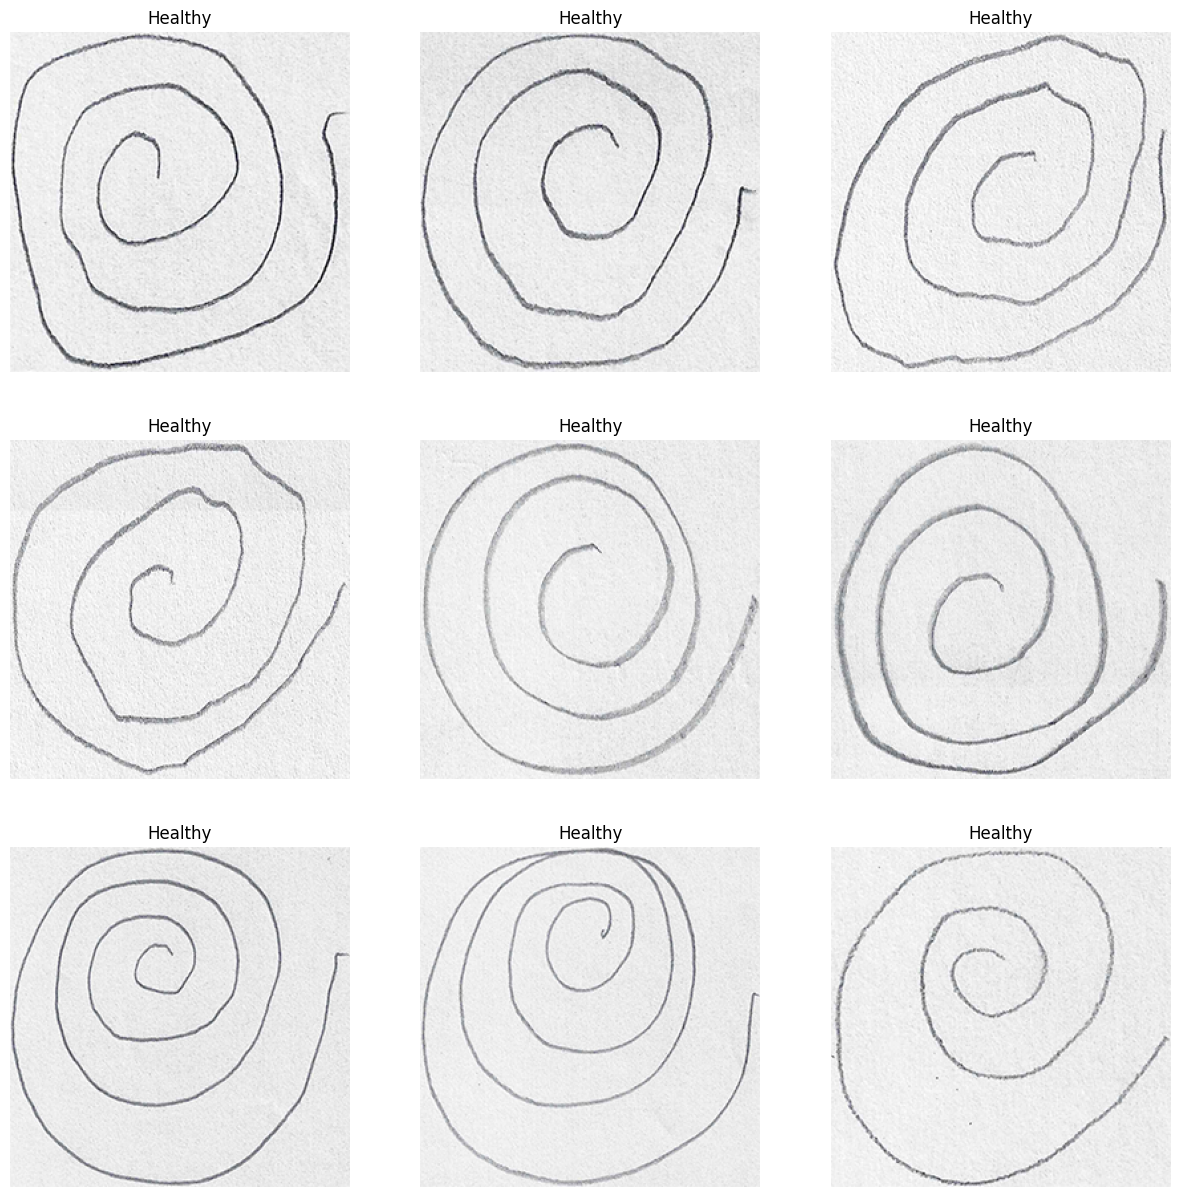

In [9]:
plot_figure(y,'Healthy')

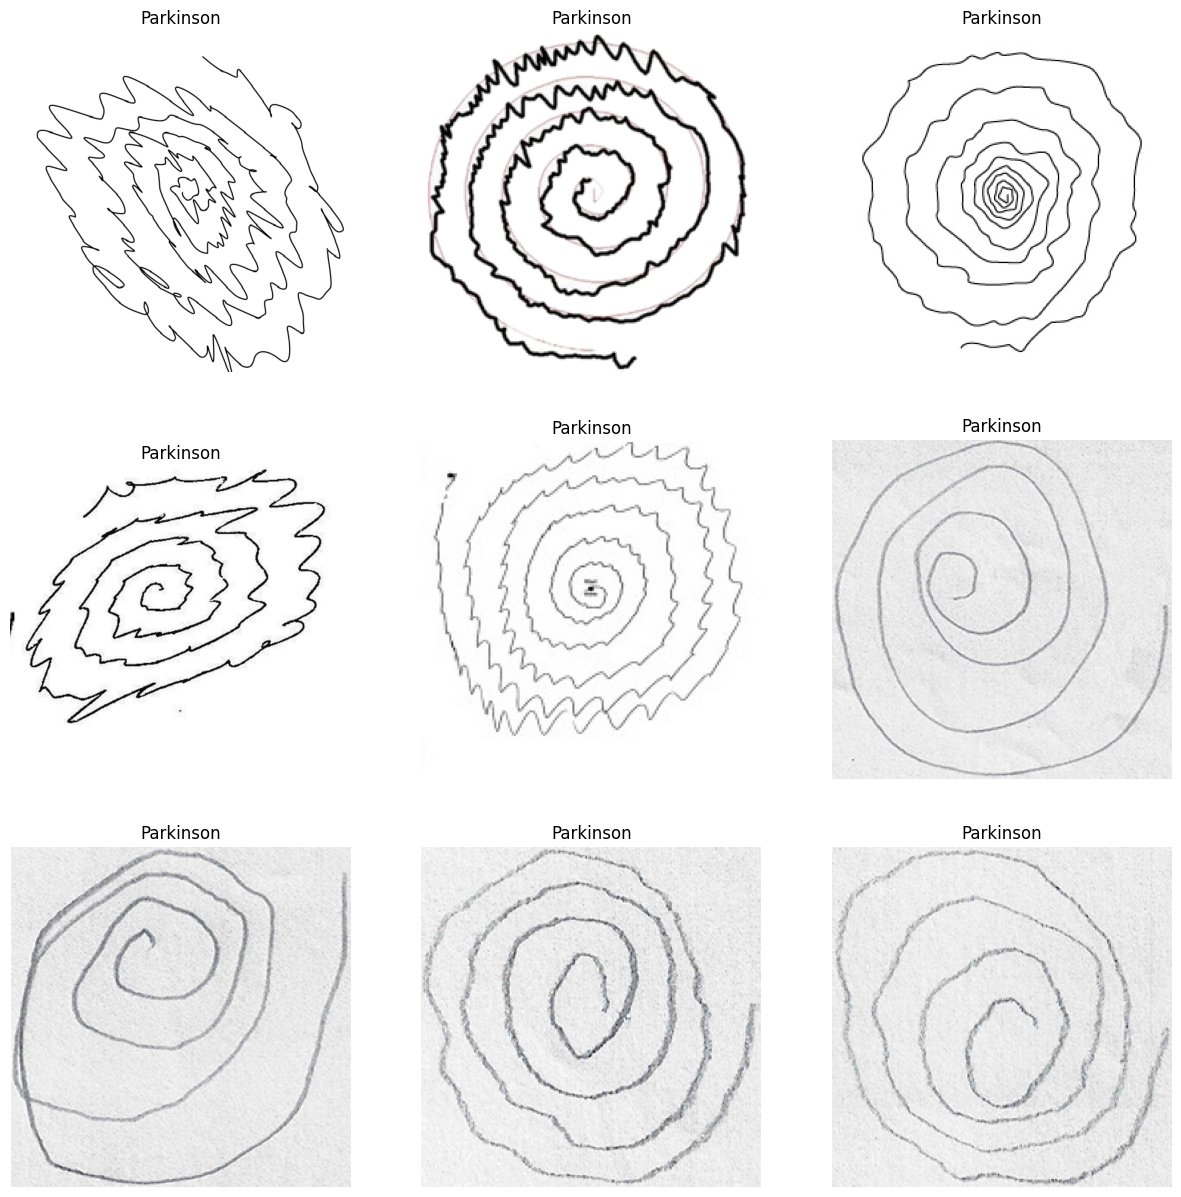

In [10]:
plot_figure(x,'Parkinson')

In [11]:


# Update the extract_features function to include DWT coefficients
def extract_features(images):
    features = []
    for img in images:
        # HOG features
        hog_features = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
        
        # LBP features
        lbp = local_binary_pattern(img, 8, 1, method='uniform')
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9), density=True)
        
        # Gabor features
        frequency = 0.4
        thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
        gabor_features = []
        for theta in thetas:
            gabor_real, gabor_imaginary = np.real(gabor_kernel(frequency, theta=theta)), np.imag(gabor_kernel(frequency, theta=theta))
            gabor_features.append(np.mean(ndi.convolve(img, gabor_real)))
            gabor_features.append(np.mean(ndi.convolve(img, gabor_imaginary)))
        
        # DWT coefficients
        coeffs = pywt.dwt2(img, 'haar')
        cA, (cH, cV, cD) = coeffs
        dwt_features = np.concatenate((cA.ravel(), cH.ravel(), cV.ravel(), cD.ravel()))
        
        # Concatenate all features
        all_features = np.concatenate((hog_features, lbp_hist, gabor_features, dwt_features))
        features.append(all_features)
    return np.array(features)



In [12]:
def preprocess_images(images):
    processed_images = []
    for img in images:
        # Resize image to (200, 200)
        img_resized = cv2.resize(img, (200, 200))
        
        # # Thresholding
        thresholded_image = cv2.threshold(img_resized, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        
        processed_images.append(thresholded_image)
    return np.array(processed_images)

In [13]:
import os
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
from sklearn.model_selection import train_test_split
# Function to load images and labels

def load_data(data_dir):
    images = []
    labels = []
    for label, category in enumerate(['healthy', 'parkinson']):
        label_dir = os.path.join(data_dir, category)
        for image_file in os.listdir(label_dir):
            img_path = os.path.join(label_dir, image_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                # Ensure all images have the same shape
                img = cv2.resize(img, (200, 200))  # Replace desired_width and desired_height with your desired dimensions
                images.append(img)
                labels.append(label)  # Assigning 0 for healthy and 1 for Parkinson's
    return np.array(images), np.array(labels)



In [14]:
# Load training and testing data
wave_training_healthy_images, wave_training_healthy_labels = load_data('spiral/training')
wave_training_parkinson_images, wave_training_parkinson_labels = load_data('spiral/training')
wave_test_healthy_images, wave_test_healthy_labels = load_data('spiral/testing')
wave_test_parkinson_images, wave_test_parkinson_labels = load_data('spiral/testing')

# Combine training and testing data
X_train = np.concatenate((wave_training_healthy_images, wave_training_parkinson_images), axis=0)
y_train = np.concatenate((wave_training_healthy_labels, wave_training_parkinson_labels), axis=0)
X_test = np.concatenate((wave_test_healthy_images, wave_test_parkinson_images), axis=0)
y_test = np.concatenate((wave_test_healthy_labels, wave_test_parkinson_labels), axis=0)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)



Shape of X_train: (154, 200, 200)
Shape of X_test: (60, 200, 200)
Shape of y_train: (154,)
Shape of y_test: (60,)


In [15]:
print(X_test[1].shape)
# Preprocess images (if needed)
X_train_preprocessed = preprocess_images(X_train)
X_test_preprocessed = preprocess_images(X_test)

print("Shape of X_train_preprocessed:", X_train_preprocessed.shape)
print("Shape of X_train_preprocessed:", X_test_preprocessed.shape)




(200, 200)
Shape of X_train_preprocessed: (154, 200, 200)
Shape of X_train_preprocessed: (60, 200, 200)


In [16]:
# Extract features
X_train_features = extract_features(X_train_preprocessed)
X_test_features = extract_features(X_test_preprocessed)

print("Shape of training features:", X_train_features.shape)
print("Shape of testing features:", X_test_features.shape)

Shape of training features: (154, 60753)
Shape of testing features: (60, 60753)


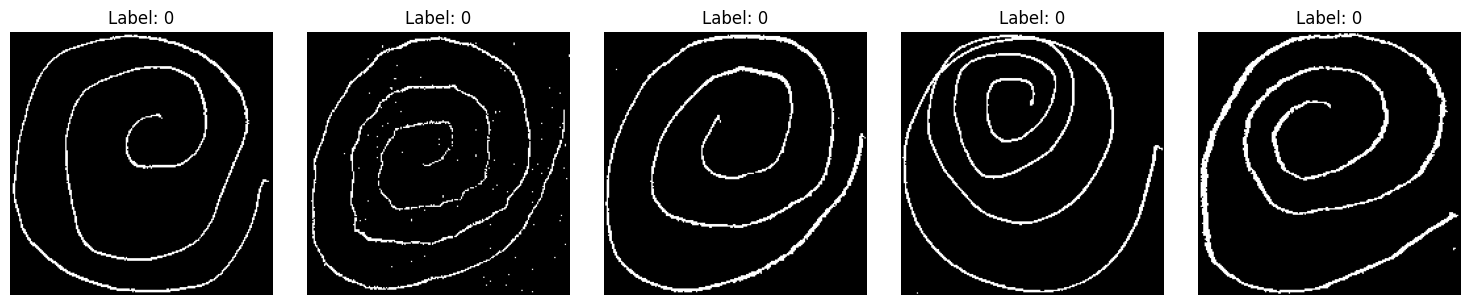

In [17]:
import matplotlib.pyplot as plt

# Function to display preprocessed images
def display_images(images, labels, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].set_title('Label: {}'.format(labels[i]))
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Display preprocessed images
display_images(X_test_preprocessed, y_test)


In [18]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define the SVM classifier
svm_classifier = SVC(kernel='rbf')

# Train the classifier
svm_classifier.fit(X_train_features, y_train)

# Predict on the training set
train_predictions = svm_classifier.predict(X_train_features)

# Calculate accuracy on the training set
train_accuracy = accuracy_score(y_train, train_predictions)
print("Training Accuracy:", train_accuracy)


Training Accuracy: 1.0


In [19]:
# Predict on the test set
test_predictions = svm_classifier.predict(X_test_features)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, test_predictions)
print("Test Accuracy:", test_accuracy)


Test Accuracy: 0.8333333333333334


In [20]:
def preprocess_images(images):
        processed_images = []
        # Resize image to (200, 200)
        img_resized = cv2.resize(images, (200, 200))
        
        # # Thresholding
        thresholded_image = cv2.threshold(img_resized, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        
        processed_images.append(thresholded_image)
        return np.array(processed_images)

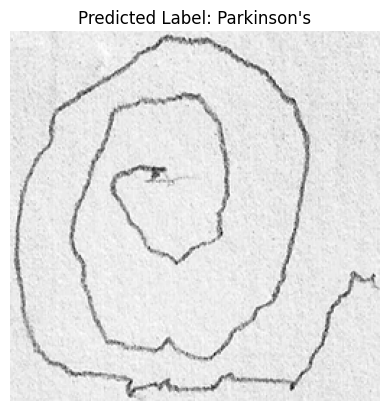

In [21]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image_path = 'spiral/testing/parkinson/V03PE07.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Preprocess the image (assuming you have a preprocess_images function)
image_preprocessed = preprocess_images(image)

# Extract features from the preprocessed image (assuming you have an extract_features function)
image_features = extract_features(image_preprocessed)

# Reshape the features array to match the expected input shape of the model
image_features = image_features.reshape(1, -1)

# Use the trained model to predict the label of the image
prediction = svm_classifier.predict(image_features)

# Display the image
plt.imshow(image, cmap='gray')
plt.title("Predicted Label: {}".format("Healthy" if prediction == 0 else "Parkinson's"))
plt.axis('off')
plt.show()


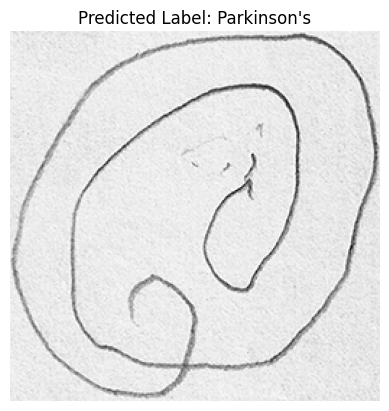

In [22]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image_path = 'spiral/testing/parkinson/V06PE01.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Preprocess the image (assuming you have a preprocess_images function)
image_preprocessed = preprocess_images(image)

# Extract features from the preprocessed image (assuming you have an extract_features function)
image_features = extract_features(image_preprocessed)

# Reshape the features array to match the expected input shape of the model
image_features = image_features.reshape(1, -1)

# Use the trained model to predict the label of the image
prediction = svm_classifier.predict(image_features)

# Display the image
plt.imshow(image, cmap='gray')
plt.title("Predicted Label: {}".format("Healthy" if prediction == 0 else "Parkinson's"))
plt.axis('off')
plt.show()


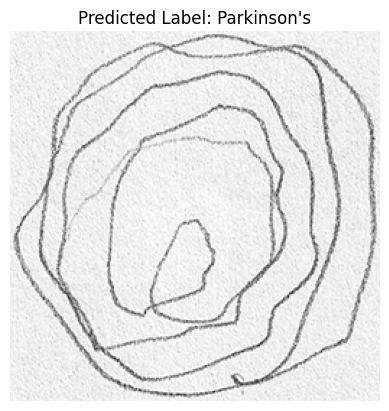

In [23]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image_path = 'spiral/testing/parkinson/V14PE03.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Preprocess the image (assuming you have a preprocess_images function)
image_preprocessed = preprocess_images(image)

# Extract features from the preprocessed image (assuming you have an extract_features function)
image_features = extract_features(image_preprocessed)

# Reshape the features array to match the expected input shape of the model
image_features = image_features.reshape(1, -1)

# Use the trained model to predict the label of the image
prediction = svm_classifier.predict(image_features)

# Display the image
plt.imshow(image, cmap='gray')
plt.title("Predicted Label: {}".format("Healthy" if prediction == 0 else "Parkinson's"))
plt.axis('off')
plt.show()


In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest classifier
rf_classifier.fit(X_train_features, y_train)

# Predict on the training set
rf_train_predictions = rf_classifier.predict(X_train_features)

# Calculate training accuracy
rf_train_accuracy = accuracy_score(y_train, rf_train_predictions)
print("Random Forest Training Accuracy:", rf_train_accuracy)

Random Forest Training Accuracy: 1.0


In [25]:


# Predict on the test set
rf_predictions = rf_classifier.predict(X_test_features)

# Calculate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Random Forest Accuracy:", rf_accuracy)


Random Forest Accuracy: 0.8666666666666667


In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Define Logistic Regression classifier
lr_classifier = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', random_state=42)

# Train the Logistic Regression classifier
lr_classifier.fit(X_train_features, y_train)

# Predict on the training set
lr_train_predictions = lr_classifier.predict(X_train_features)

# Calculate training accuracy
lr_train_accuracy = accuracy_score(y_train, lr_train_predictions)
print("Logistic Regression Training Accuracy:", lr_train_accuracy)

# Predict on the test set
lr_test_predictions = rf_classifier.predict(X_test_features)

# Calculate testing accuracy
lr_test_accuracy = accuracy_score(y_test, lr_test_predictions)
print("Logistic Regression Testing Accuracy:", lr_test_accuracy)


Logistic Regression Training Accuracy: 1.0
Logistic Regression Testing Accuracy: 0.8666666666666667


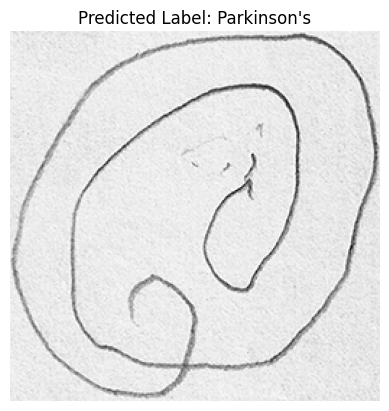

In [27]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image_path = 'spiral/testing/parkinson/V06PE01.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Preprocess the image (assuming you have a preprocess_images function)
image_preprocessed = preprocess_images(image)

# Extract features from the preprocessed image (assuming you have an extract_features function)
image_features = extract_features(image_preprocessed)

# Reshape the features array to match the expected input shape of the model
image_features = image_features.reshape(1, -1)

# Use the trained model to predict the label of the image
prediction = rf_classifier.predict(image_features)

# Display the image
plt.imshow(image, cmap='gray')
plt.title("Predicted Label: {}".format("Healthy" if prediction == 0 else "Parkinson's"))
plt.axis('off')
plt.show()

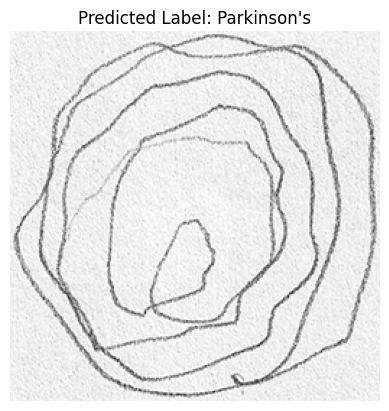

In [28]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image_path = 'spiral/testing/parkinson/V14PE03.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Preprocess the image (assuming you have a preprocess_images function)
image_preprocessed = preprocess_images(image)

# Extract features from the preprocessed image (assuming you have an extract_features function)
image_features = extract_features(image_preprocessed)

# Reshape the features array to match the expected input shape of the model
image_features = image_features.reshape(1, -1)

# Use the trained model to predict the label of the image
prediction = rf_classifier.predict(image_features)

# Display the image
plt.imshow(image, cmap='gray')
plt.title("Predicted Label: {}".format("Healthy" if prediction == 0 else "Parkinson's"))
plt.axis('off')
plt.show()


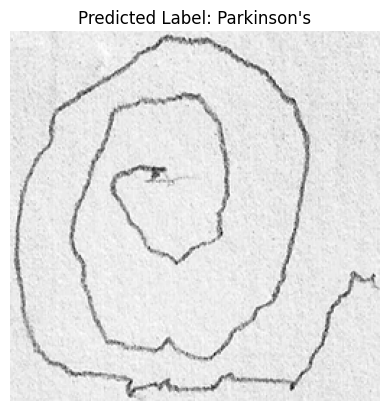

In [29]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image_path = 'spiral/testing/parkinson/V03PE07.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Preprocess the image (assuming you have a preprocess_images function)
image_preprocessed = preprocess_images(image)

# Extract features from the preprocessed image (assuming you have an extract_features function)
image_features = extract_features(image_preprocessed)

# Reshape the features array to match the expected input shape of the model
image_features = image_features.reshape(1, -1)

# Use the trained model to predict the label of the image
prediction = rf_classifier.predict(image_features)

# Display the image
plt.imshow(image, cmap='gray')
plt.title("Predicted Label: {}".format("Healthy" if prediction == 0 else "Parkinson's"))
plt.axis('off')
plt.show()


In [30]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict

# Step 1: Bagging and Boosting
# Random Forest (Bagging)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_features, y_train)
rf_predictions = rf_classifier.predict(X_test_features)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Random Forest Accuracy:", rf_accuracy)

# AdaBoost (Boosting)
adaboost_classifier = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost_classifier.fit(X_train_features, y_train)
adaboost_predictions = adaboost_classifier.predict(X_test_features)
adaboost_accuracy = accuracy_score(y_test, adaboost_predictions)
print("AdaBoost Accuracy:", adaboost_accuracy)

# Gradient Boosting (Boosting)
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_classifier.fit(X_train_features, y_train)
gb_predictions = gb_classifier.predict(X_test_features)
gb_accuracy = accuracy_score(y_test, gb_predictions)
print("Gradient Boosting Accuracy:", gb_accuracy)

# Step 2: Stacking
# Train base models
base_rf = RandomForestClassifier(n_estimators=100, random_state=42)
base_adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
base_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

base_models = [base_rf, base_adaboost, base_gb]
stacking_train_predictions = []

for model in base_models:
    model.fit(X_train_features, y_train)
    train_predictions = model.predict(X_train_features)
    stacking_train_predictions.append(train_predictions)

# Stack base model predictions to create meta-features
stacking_train_predictions = np.array(stacking_train_predictions).T

# Train meta-model (Logistic Regression)
meta_model = LogisticRegression()
meta_model.fit(stacking_train_predictions, y_train)

# Make predictions on test data for base models
stacking_test_predictions = []

for model in base_models:
    test_predictions = model.predict(X_test_features)
    stacking_test_predictions.append(test_predictions)

# Stack base model predictions to create meta-features for test data
stacking_test_predictions = np.array(stacking_test_predictions).T

# Predict using meta-model
stacking_predictions = meta_model.predict(stacking_test_predictions)
stacking_accuracy = accuracy_score(y_test, stacking_predictions)
print("Stacking Accuracy:", stacking_accuracy)


Random Forest Accuracy: 0.8666666666666667
AdaBoost Accuracy: 0.7666666666666667
Gradient Boosting Accuracy: 0.7333333333333333
Stacking Accuracy: 0.8


In [31]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_features, y_train)
rf_predictions = rf_classifier.predict(X_test_features)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Random Forest Accuracy:", rf_accuracy)

# Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
gb_classifier.fit(X_train_features, y_train)
gb_predictions = gb_classifier.predict(X_test_features)
gb_accuracy = accuracy_score(y_test, gb_predictions)
print("Gradient Boosting Accuracy:", gb_accuracy)

# Support Vector Machine (SVM) Classifier
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)
svm_classifier.fit(X_train_features, y_train)
svm_predictions = svm_classifier.predict(X_test_features)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Accuracy:", svm_accuracy)

# Logistic Regression Classifier
lr_classifier = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', random_state=42)
lr_classifier.fit(X_train_features, y_train)
lr_predictions = lr_classifier.predict(X_test_features)
lr_accuracy = accuracy_score(y_test, lr_predictions)
print("Logistic Regression Accuracy:", lr_accuracy)


Random Forest Accuracy: 0.8666666666666667
Gradient Boosting Accuracy: 0.7666666666666667
SVM Accuracy: 0.7666666666666667
Logistic Regression Accuracy: 0.8333333333333334


In [32]:
accuracy_scores = {
    'Model': ['Random Forest', 'Gradient Boosting', 'SVM', 'Logistic Regression'],
    'Accuracy': [rf_accuracy, gb_accuracy, svm_accuracy, lr_accuracy]
}


In [33]:
accuracy_df = pd.DataFrame(accuracy_scores,index=['a','b','c','d'])

# Display the DataFrame
print(accuracy_df)

                 Model  Accuracy
a        Random Forest  0.866667
b    Gradient Boosting  0.766667
c                  SVM  0.766667
d  Logistic Regression  0.833333


In [34]:
accuracy_df

Model  Accuracy
a        Random Forest  0.866667
b    Gradient Boosting  0.766667
c                  SVM  0.766667
d  Logistic Regression  0.833333

In [35]:
from sklearn.metrics import confusion_matrix, classification_report


# Random Forest Classifier
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)
rf_class_report = classification_report(y_test, rf_predictions)

# Gradient Boosting Classifier
gb_conf_matrix = confusion_matrix(y_test, gb_predictions)
gb_class_report = classification_report(y_test, gb_predictions)

# Support Vector Machine (SVM) Classifier
svm_conf_matrix = confusion_matrix(y_test, svm_predictions)
svm_class_report = classification_report(y_test, svm_predictions)

# Logistic Regression Classifier
lr_conf_matrix = confusion_matrix(y_test, lr_predictions)
lr_class_report = classification_report(y_test, lr_predictions)


Random Forest Confusion Matrix:



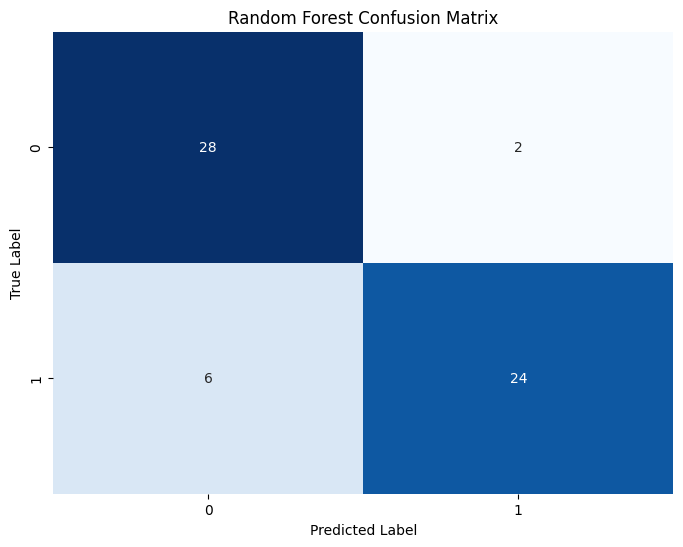


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.93      0.87        30
           1       0.92      0.80      0.86        30

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60



In [36]:
import seaborn as sns
print("Random Forest Confusion Matrix:\n")
plt.figure(figsize=(8, 6))
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
print("\nRandom Forest Classification Report:\n", rf_class_report)

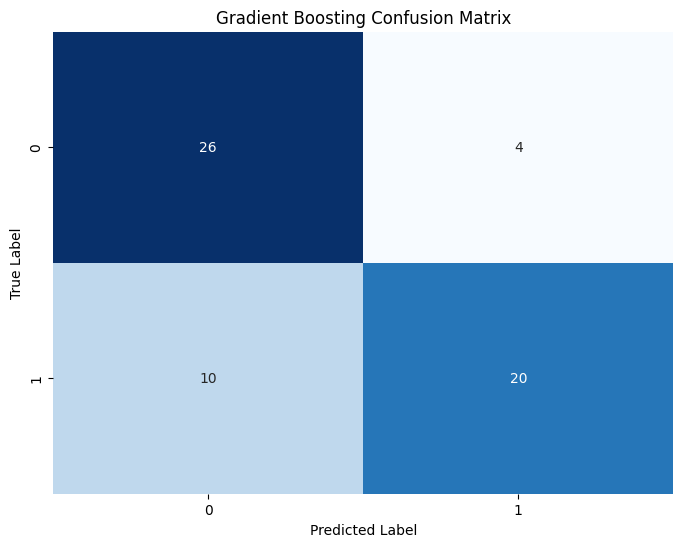

In [37]:
svm_conf_matrix = confusion_matrix(y_test, svm_predictions)
svm_class_report = classification_report(y_test, svm_predictions)

gb_conf_matrix = confusion_matrix(y_test, gb_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(gb_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Gradient Boosting Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

gb_class_report = classification_report(y_test, gb_predictions)

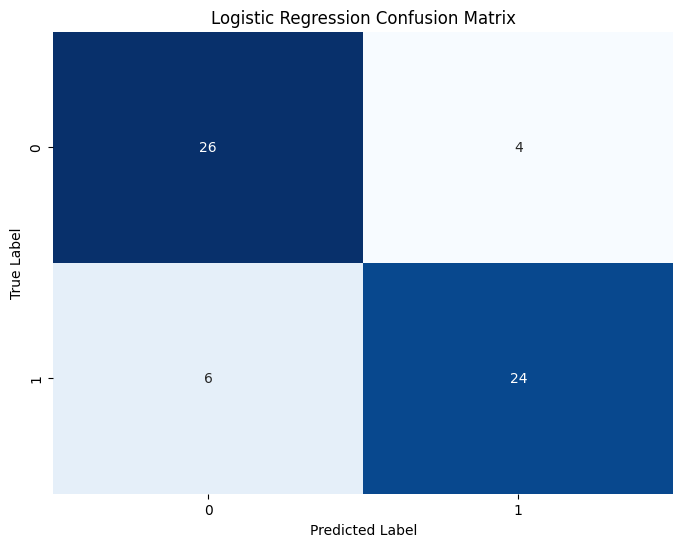

In [38]:
lr_conf_matrix = confusion_matrix(y_test, lr_predictions)
lr_class_report = classification_report(y_test, lr_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(lr_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

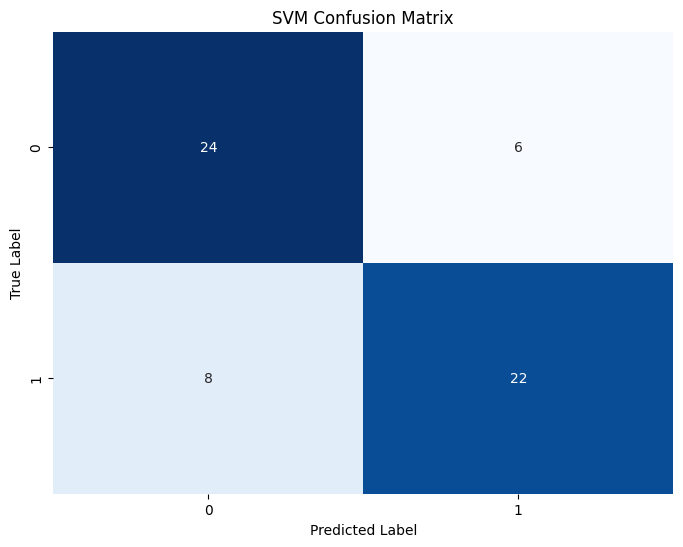

In [39]:
plt.figure(figsize=(8, 6))
sns.heatmap(svm_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [40]:
import pickle
with open('rf_classifier.pkl','wb') as file:
    pickle.dump(rf_classifier,file)